In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [9]:
df = pd.read_csv('/content/soil dataset clustering.csv')

In [10]:
df.head(5)

,created_at,entry_id,ambient air temp,ambient air moisture,soil temperature,soil moisture,soil pH,status
0,2021-03-18 00:58:51 EAT,1,22,68,23,55,8,Smart Farm Sensor OK
1,2021-03-18 00:58:57 EAT,2,22,67,23,55,8,Smart Farm Sensor OK
2,2021-03-18 00:59:03 EAT,3,22,67,23,55,8,Smart Farm Sensor OK
3,2021-03-18 00:59:09 EAT,4,22,67,23,55,8,Smart Farm Sensor OK
4,2021-03-18 00:59:15 EAT,5,22,67,23,55,8,Smart Farm Sensor OK


In [11]:
df['status'].value_counts()

,count
status,
Smart Farm Sensor OK,99999


In [12]:
df['status'].unique()

array(['Smart Farm Sensor OK'], dtype=object)

In [13]:
df.drop(columns='status', inplace=True)

In [14]:
df.drop(columns='entry_id', inplace=True)

In [15]:
df.drop(columns='created_at', inplace=True)

## Exploratory Data Analysis

In [16]:
df.shape

(99999, 5)

Terdapat 99999 baris dan 8 kolom pada data ini

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   ambient air temp      99999 non-null  int64
 1   ambient air moisture  99999 non-null  int64
 2   soil temperature      99999 non-null  int64
 3   soil moisture         99999 non-null  int64
 4   soil pH               99999 non-null  int64
dtypes: int64(5)
memory usage: 3.8 MB


In [18]:
df.isnull().sum()

,0
ambient air temp,0
ambient air moisture,0
soil temperature,0
soil moisture,0
soil pH,0


Tidak terdapat data yang kosong, sehinggal tidak perlu melakukan handling missing value

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient air temp,99999.0,22.952740,1.642827,20.0,22.0,23.0,24.0,30.0
ambient air moisture,99999.0,64.786368,11.505256,37.0,55.0,64.0,73.0,99.0
soil temperature,99999.0,23.835318,1.436803,21.0,23.0,24.0,25.0,32.0
soil moisture,99999.0,50.151752,8.194580,29.0,44.0,50.0,56.0,95.0
soil pH,99999.0,4.426814,2.687360,-1.0,0.0,6.0,6.0,9.0


Melihat statistik deskriptif pada dataset ini

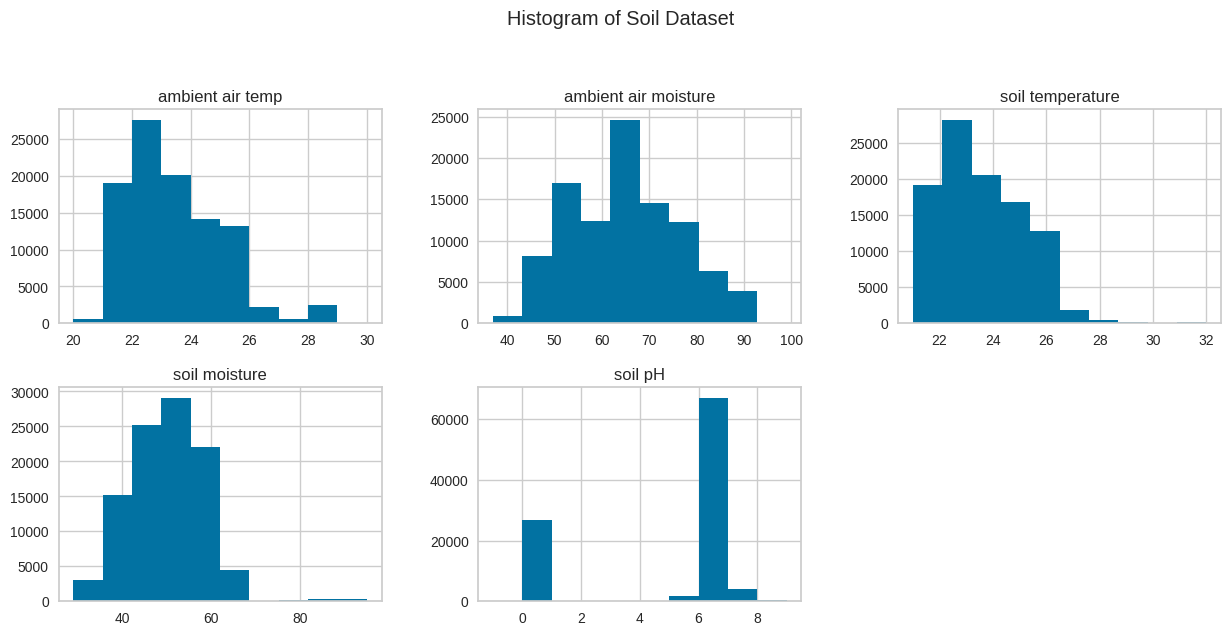

In [20]:
def plot_histograms(data):
    data.hist(bins=10, figsize=(15,10), layout=(3,3))
    plt.suptitle("Histogram of Soil Dataset")
    plt.show()

plot_histograms(df)

Dari histogram terlihat bahwa distribusi dari kolom tidak berdistribusi normal. Oleh karena itu, kita perlu lakukan normalisasi supaya skala datanya sama

In [21]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

outlier_counts = {}
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    outlier_counts[col] = count_outliers_iqr(df[col])

outliers_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outliers Count'])

outliers_counts_df

,Column,Outliers Count
0,ambient air temp,2586
1,ambient air moisture,0
2,soil temperature,265
3,soil moisture,870
4,soil pH,0


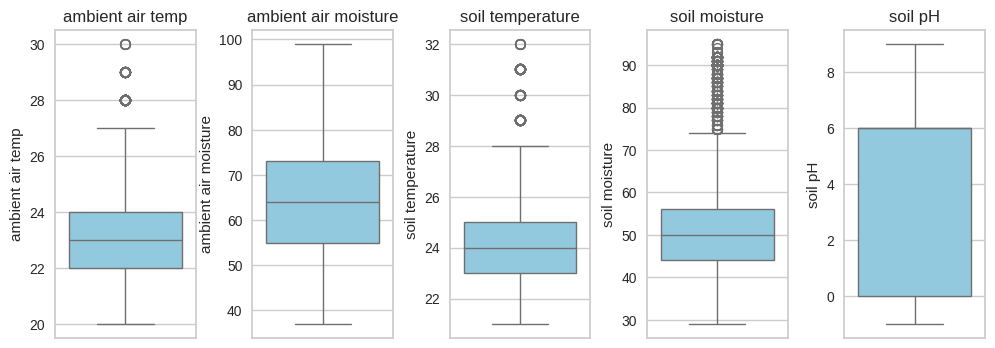

In [22]:
def box_plot(df):
  variables = df.select_dtypes(exclude = 'object').columns
  fig, axes = plt.subplots(1, 5, figsize = (12, 4))
  fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

  for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df, color = "skyblue", ax=axes[i])
    axes[i].set_title(var)

  plt.show()

box_plot(df)

Terlihat dari boxplot pada kolom `soil temperature` dan  `soil moisture`
 terdapat outliers yang lumayan cukup banyak. Bisa dilakukan handling outliers dengan di drop, namun dengan jumlah data yang sangat kecil maka akan kehilangan informasi yang berguna dan juga dari hasil statistik deskriptif.

# Preprocessing

In [23]:
scaler = MinMaxScaler()

x = scaler.fit_transform(df)

Menggunakan MinMaxScaler karena akan mengubah skala datanya menjadi range 0 - 1

# MODELLING

## K-Means

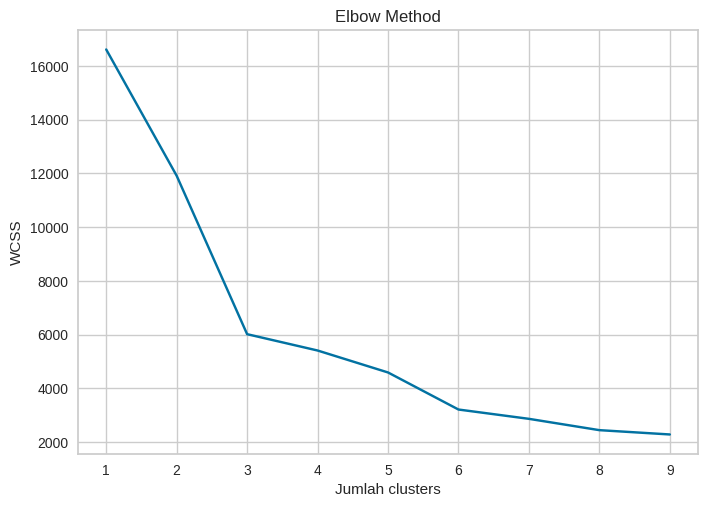

In [24]:
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Jumlah clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method merupakan pendekatan yang mencari titik dimana penurunan inersia mulai melambat, membentuk grafik yang merupai bentuk elbow. Inersia mengukur seberapa dekat titik-titik data dengan pusat cluster. Pengukuran inersia dilakukan dengan menggunakan **Within-Cluster Sum of Squares (WCSS)**. Penentuan jumlah cluster didasarkan pada penurunan inersia pada grafik. Dari elbow method diatas jumlah cluster optimal yang bisa digunakan yaitu 2 cluster atau 3 cluster, karena terlihat penurunan inersia yang mulai melambat pada cluster 2 atau 3

In [25]:
km2 = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_pred_km2 = km2.fit_predict(x)

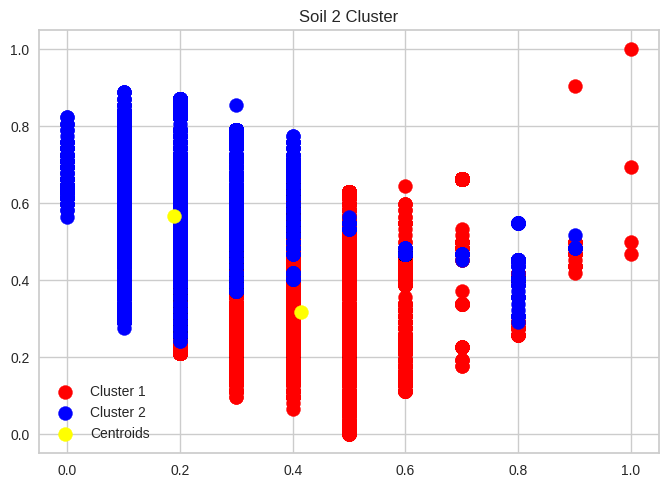

In [26]:
plt.scatter(x[y_pred_km2 == 0, 0], x[y_pred_km2 == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(x[y_pred_km2 == 1, 0], x[y_pred_km2 == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(km2.cluster_centers_[:, 0], km2.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Soil 2 Cluster')
plt.legend()
plt.show()

In [27]:
df['Label_K-Means2'] = km2.labels_
df.head()

,ambient air temp,ambient air moisture,soil temperature,soil moisture,soil pH,Label_K-Means2
0,22,68,23,55,8,1
1,22,67,23,55,8,1
2,22,67,23,55,8,1
3,22,67,23,55,8,1
4,22,67,23,55,8,1


In [28]:
df['Label_K-Means2'].value_counts()

,count
Label_K-Means2,
1,52780
0,47219


In [29]:
km = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_pred_km = km.fit_predict(x)

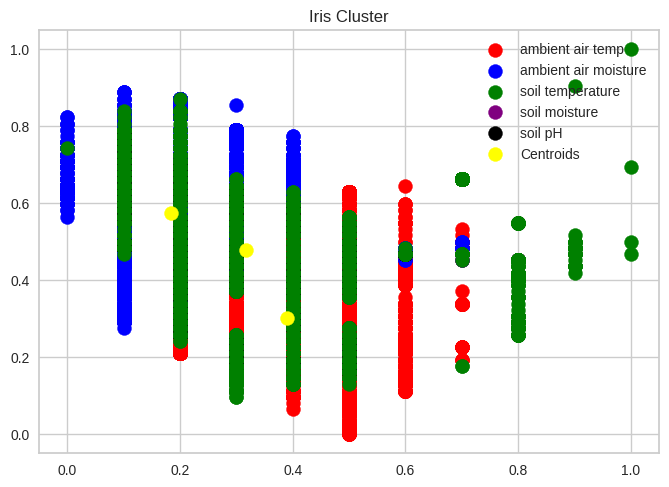

In [30]:
plt.scatter(x[y_pred_km == 0, 0], x[y_pred_km == 0, 1], s = 100, c = 'red', label = 'ambient air temp')
plt.scatter(x[y_pred_km == 1, 0], x[y_pred_km == 1, 1], s = 100, c = 'blue', label = 'ambient air moisture')
plt.scatter(x[y_pred_km == 2, 0], x[y_pred_km == 2, 1], s = 100, c = 'green', label = 'soil temperature')
plt.scatter(x[y_pred_km == 3, 0], x[y_pred_km == 3, 1], s = 100, c = 'purple', label = 'soil moisture')
plt.scatter(x[y_pred_km == 4, 0], x[y_pred_km == 4, 1], s = 100, c = 'black', label = 'soil pH')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Iris Cluster')
plt.legend()
plt.show()

In [31]:
df['Label_K-Means'] = km.labels_
df.head()

,ambient air temp,ambient air moisture,soil temperature,soil moisture,soil pH,Label_K-Means2,Label_K-Means
0,22,68,23,55,8,1,1
1,22,67,23,55,8,1,1
2,22,67,23,55,8,1,1
3,22,67,23,55,8,1,1
4,22,67,23,55,8,1,1


In [32]:
df['Label_K-Means'].value_counts()

,count
Label_K-Means,
0,36884
1,36346
2,26769


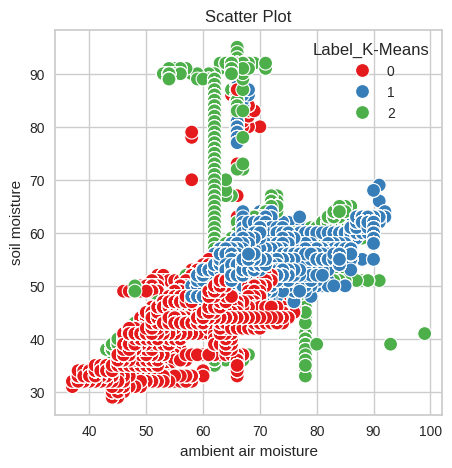

In [33]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'ambient air moisture', y = 'soil moisture', hue = 'Label_K-Means', data = df, palette = 'Set1', s=100);
plt.title("Scatter Plot")
plt.show()

# DB SCAN

In [32]:
#pip install scikit-learn

In [33]:
#from sklearn.cluster import DBSCAN
#from sklearn.preprocessing import MinMaxScaler

In [34]:
#scaler = MinMaxScaler()

In [35]:
#x = scaler.fit_transform(df)

In [ ]:
#db = DBSCAN(eps=0.4, min_samples=5)
#db.fit(x)

#y_pred_db = db.labels_

In [ ]:
#df['Label_DB-Scan'] = db.labels_
#df.head()

In [2]:
#df['Label_DB-Scan'].value_counts()

NameError: name 'df' is not defined

In [3]:
#plt.figure(figsize=(10, 5))
#sns.scatterplot(x = 'sepal length', y = 'sepal width', hue = 'Label_DB-Scan', data = df, palette = 'Set1', s=100);

NameError: name 'plt' is not defined

# EVALUATION

### K-Means

In [34]:
e_km2 = silhouette_score(x, y_pred_km2)
dbi_km2 = davies_bouldin_score(x, y_pred_km2)

print('Silhouette Score K-Means 2 Cluster:', e_km2)
print('Davies-Bouldin Index K-Means 2 Cluster:', dbi_km2)

Silhouette Score K-Means 2 Cluster: 0.29281695101240074
Davies-Bouldin Index K-Means 2 Cluster: 1.468124990393879


Silhouette Score mengukur seberapa baik setiap titik data dalam cluster tertentu ditempatkan dan sejauh mana titik data tersebut berada dari cluster tetangga terdekatnya. Silhoutte Score berada pada -1 sampai 1. Nilai positif menunjukan bahwa titik data lebih dekat dengan clusternya sendiri daripada cluster tetangga dekatnya. Sedangkan nilai negatif menunjukan sebaliknya, yaitu bahwa titik data mungkin ditempatkan pada cluster yang salah. Nilai 0 menunjukan bahwa titik data berada di dekat batas antara dua cluster. Silhoutte Score positif yang tinggi menunjukan bahwa objek berada dalam cluster yang sesuai. Dari hasil Silhoutte Score menggunakan K-Means 2 cluster dapat dilihat mendapat score 0.29 yang menunjukan nilai yang kurang baik karena cluster tidak dapat terpisah dengan baik dan jelas.

Davies-Bouldin Index menghitung rata-rata nilai setiap titik pada himpunan data. Perhitungan nilai setiap titik adalah jumlah nilai compactness yang dibagi dengan jarak antara kedua titik pusat klaster sebagai separation. Jumlah klaster terbaik ditunjukkan dengan nilai DB yang semakin kecil (Davies & Bouldin, 1979). Dari hasil pengukuran menggunakan Davies-Bouldin Index diatas menunjukan hasil yang cukup optimal yang mengindikasikan bahwa cluster memiliki separasi yang cukup jelas

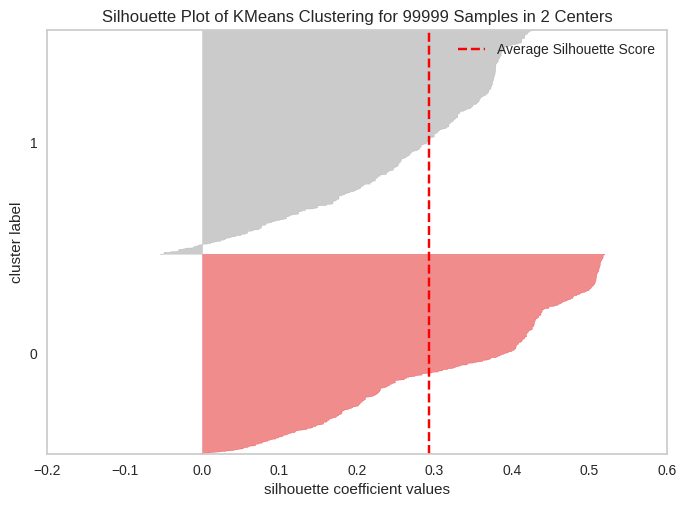

In [35]:
silhouette_viz = SilhouetteVisualizer(km2)
silhouette_viz.fit(x)
plt.grid(False)
silhouette_viz.show()
plt.show()

Dari grafik diatas, cluster 1 dan 0 memiliki lebar yang berbeda yang menandakan kedua cluster tersebut memiliki jumlah anggota yang tidak sama. Sebagian besar data memiliki score silhouette coefficient positif, menandakan bahwa data berada lebih dekat dengan clusternya sendiri daripada cluster lain. Namun terdapat beberapa nilai yang mendekati nol yang menandakan bahwa data tersebut berada di perbatasan antara dua cluster. Tidak ditemukan score silhouette coefficient negatif yang berarti tidak ada data yang lebih dekat ke cluster lain daripada cluster sendiri.

In [36]:
e_km = silhouette_score(x, y_pred_km)
dbi_km = davies_bouldin_score(x, y_pred_km)

print('Silhouette Score K-Means 3 Cluster:', e_km)
print('Davies-Bouldin Index K-Means 3 Cluster 3:', dbi_km)

Silhouette Score K-Means 3 Cluster: 0.42567613703366436
Davies-Bouldin Index K-Means 3 Cluster 3: 0.8506882655528707


Nilai Silhouette Score sebesar 0.425 menandakan kualitas clustering yang cukup meskipun tidak optimal. Score tersebut menunjukan separasi antar cluster tidak terlalu jelas jika dibandingkan dengan clustering sebelumnya menggunakan 2 cluster. Score Davies-Bouldin Index 3 cluster yang sebesar 0.85 menunjukan score lebih rendah daripada nilai pada clustering dengan 2 cluster yang menunjukan bahwa cluster lebih tertata dan terpisah secara signifikan

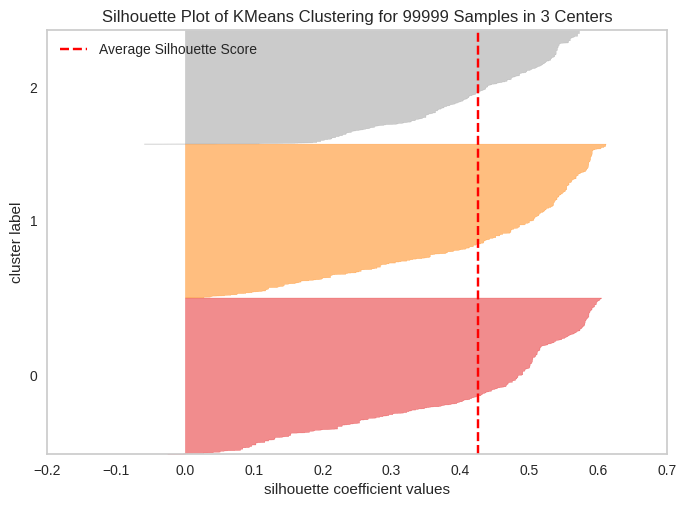

In [37]:
silhouette_viz = SilhouetteVisualizer(km)
silhouette_viz.fit(x)
plt.grid(False)
silhouette_viz.show()
plt.show()

Secara keseluruhan, rata-rata silhouette score (ditunjukkan oleh garis merah vertikal) berada di sekitar 0.4, yang mengindikasikan bahwa hasil clustering cukup baik, tetapi belum optimal. Hal ini menunjukkan bahwa terdapat beberapa data yang kurang sesuai dengan klusternya, sehingga perlu evaluasi lebih lanjut, seperti mencoba jumlah kluster yang berbeda, algoritma clustering lainnya, atau melakukan preprocessing data tambahan.